In [30]:
import tenseal as ts
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report


#improve , performance, rounds, 

In [32]:
import pandas as pd

# Load your datasets
dataset1 = pd.read_csv("dataset1.csv")
dataset2 = pd.read_csv("dataset2.csv")
print(dataset1.head())
print(dataset2.head())


          dr        id         x0         x1         x2         x3         x4  \
0  17.247447  69713556  98.573369  64.701596   4.374005  76.705994  95.553074   
1  28.013769  15727422  66.085030  21.745970  89.547778  78.822314  34.201912   
2  49.076994  79950559  93.711319  86.027265  84.941576  91.624861  96.074557   
3  57.287502  67356212  85.910043   2.725665   8.727508  66.915904  95.193664   
4  85.693853  89014544  45.959033  47.678536  33.906799  88.199954  32.407915   

          x5         x6         x7         x8         x9  
0  21.684720  52.519343  59.404645  85.862287  96.072936  
1  42.006270  44.125023  39.561638  99.037961  85.499318  
2  18.482570  35.540330  61.822073  96.355584  25.236448  
3  91.372558  76.402465  12.546064  39.474765  59.076848  
4  24.949828  80.418640  81.350156  86.486812  56.812471  
         ar        id  fr
0  1.517801  69713556   0
1  4.614905  15727422   0
2  5.198290  79950559   1
3  4.323623  67356212   0
4  1.797798  89014544   0


In [34]:
# Merge datasets on 'id'
merged = pd.merge(dataset1, dataset2, on="id")

# Party 1 features (dr + x0...x9)
party1_features = ["dr"] + [f"x{i}" for i in range(10)]
X_p1 = merged[party1_features].values

# Party 2 features: 'ar'
X_p2 = merged[["ar"]].values

# Labels (fraud flag): 'fr' from Party 2
y = merged["fr"].values


In [36]:
import tenseal as ts

def create_context():
    context = ts.context(
        ts.SCHEME_TYPE.CKKS,
        poly_modulus_degree=8192,
        coeff_mod_bit_sizes=[60, 40, 40, 60],
    )
    context.generate_galois_keys()
    context.global_scale = 2**40
    return context

context = create_context()


In [38]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def local_gradient(X, y, weights):
    preds = sigmoid(np.dot(X, weights))
    error = preds - y
    grad = np.dot(X.T, error) / len(y)
    return grad
# another layer, maybe more set of weights, chekc the performance
#more parties


In [40]:
def encrypt_gradient(grad, context):
    return ts.ckks_vector(context, grad.tolist())

def decrypt_gradient(enc_grad):
    return np.array(enc_grad.decrypt())


In [42]:
weights_p1 = np.zeros(X_p1.shape[1])  # e.g., 11 features
weights_p2 = np.zeros(X_p2.shape[1])  # e.g., 1 feature


In [78]:
learning_rate = 0.1 ### test with different, its too large, try to check for less, 
num_rounds = 12 # test this also,,

total_features = len(weights_p1) + len(weights_p2)  # Total number of features combined

for round in range(num_rounds):
    print(f"Round {round + 1}")

    # Party 1 computes gradient on their features
    grad_p1 = local_gradient(X_p1, y, weights_p1)  # Shape: len(weights_p1)
    # Pad to total length, first part filled with grad_p1, rest zeros
    grad_p1_full = np.zeros(total_features)
    grad_p1_full[: len(weights_p1)] = grad_p1

    # Encrypt padded gradient from Party 1
    enc_grad_p1 = encrypt_gradient(grad_p1_full, context)

    # Party 2 computes gradient on their features
    grad_p2 = local_gradient(X_p2, y, weights_p2)  # Shape: len(weights_p2)
    # Pad to total length, zeros for first part, last part filled with grad_p2
    grad_p2_full = np.zeros(total_features)
    grad_p2_full[len(weights_p1):] = grad_p2

    # Encrypt padded gradient from Party 2
    enc_grad_p2 = encrypt_gradient(grad_p2_full, context)

    # Server aggregates encrypted gradients (element-wise addition)
    aggregated_enc_grad = enc_grad_p1 + enc_grad_p2

    # Server decrypts aggregated gradient
    aggregated_grad = decrypt_gradient(aggregated_enc_grad)  # Shape: total_features

    # Update weights for both parties by slicing the aggregated gradient
    weights_p1 -= learning_rate * aggregated_grad[: len(weights_p1)]
    weights_p2 -= learning_rate * aggregated_grad[len(weights_p1):]

    # Compute combined predictions after weight update
    z_p1 = np.dot(X_p1, weights_p1)
    z_p2 = np.dot(X_p2, weights_p2)
    z = z_p1 + z_p2

    # Apply sigmoid for probability
    y_pred_prob = 1 / (1 + np.exp(-z))

    # Classify predictions based on 0.5 threshold
    y_pred = (y_pred_prob >= 0.5).astype(int)

    # Calculate accuracy
    accuracy = np.mean(y_pred == y)

    print(f"Accuracy after round {round + 1}: {accuracy * 100:.2f}%")
    print("Weights Party 1:", weights_p1)
    print("Weights Party 2:", weights_p2)
    print()


Round 1
Accuracy after round 1: 58.50%
Weights Party 1: [12.05618924 -1.89743971 -2.32293226 -1.67597183 -1.6940355  -2.68620689
 -2.57674647 -1.50746806 -2.49453243 -2.00884174 -2.1822551 ]
Weights Party 2: [0.1094153]

Round 2
Accuracy after round 2: 56.90%
Weights Party 1: [13.77665143 -0.10754818 -0.49249171  0.12593407  0.15171794 -0.90867674
 -0.72415641  0.33000023 -0.65345151 -0.19780157 -0.45948675]
Weights Party 2: [0.1094153]

Round 3
Accuracy after round 3: 56.90%
Weights Party 1: [11.99510057 -2.07106393 -2.49176935 -1.86308352 -1.90114506 -2.86600658
 -2.77424363 -1.68550642 -2.63419613 -2.22592574 -2.35929571]
Weights Party 2: [0.1094153]

Round 4
Accuracy after round 4: 54.90%
Weights Party 1: [14.17625895 -0.04593808 -0.42024665  0.20731914  0.24059314 -0.83828162
 -0.67019201  0.4023954  -0.57921518 -0.12140972 -0.38477706]
Weights Party 2: [0.1094153]

Round 5


C:\Users\zeesh\AppData\Local\Temp\ipykernel_18632\324024374.py:43: RuntimeWarning: overflow encountered in exp
  y_pred_prob = 1 / (1 + np.exp(-z))
C:\Users\zeesh\AppData\Local\Temp\ipykernel_18632\4168527322.py:4: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Accuracy after round 5: 57.00%
Weights Party 1: [12.35932668 -2.17771619 -2.60430456 -1.96615926 -1.98012576 -2.99467265
 -2.88978947 -1.78065232 -2.74055406 -2.30999792 -2.4810672 ]
Weights Party 2: [0.1094153]

Round 6
Accuracy after round 6: 56.40%
Weights Party 1: [14.60440245 -0.11743599 -0.50398631  0.13055405  0.19728045 -0.93476105
 -0.75293956  0.3382924  -0.64067219 -0.18043769 -0.46904921]
Weights Party 2: [0.1094153]

Round 7
Accuracy after round 7: 57.90%
Weights Party 1: [12.81298085 -2.11320177 -2.5409067  -1.89545106 -1.90405773 -2.94792045
 -2.84614619 -1.71706985 -2.67916198 -2.25055657 -2.40339543]
Weights Party 2: [0.1094153]

Round 8
Accuracy after round 8: 58.90%
Weights Party 1: [14.76969927 -0.21274629 -0.59733689  0.05535624  0.10111544 -1.03580153
 -0.86438391  0.25937305 -0.73999595 -0.25096358 -0.55834156]
Weights Party 2: [0.1094153]

Round 9
Accuracy after round 9: 59.20%
Weights Party 1: [13.02485253 -2.01653131 -2.44209097 -1.78473749 -1.7833936  -2.8416

In [80]:
#examples check out, nvflare, recommenddatn system
learning_rate = 0.1
num_rounds = 50 
patience = 7     #upto how many we shpuld wait if the acc is dropping

total_features = len(weights_p1) + len(weights_p2)  # Total number of features combined
accuracy_list = []  

best_accuracy = 0
no_improve_count = 0

for round in range(num_rounds):
    print(f"Round {round + 1}")

    # Party 1 computes gradient on their features
    grad_p1 = local_gradient(X_p1, y, weights_p1)
    grad_p1_full = np.zeros(total_features)
    grad_p1_full[: len(weights_p1)] = grad_p1

    # Encrypt padded gradient from Party 1
    enc_grad_p1 = encrypt_gradient(grad_p1_full, context)

    # Party 2 computes gradient on their features
    grad_p2 = local_gradient(X_p2, y, weights_p2)
    grad_p2_full = np.zeros(total_features)
    grad_p2_full[len(weights_p1):] = grad_p2

    # Encrypt padded gradient from Party 2
    enc_grad_p2 = encrypt_gradient(grad_p2_full, context)

    # Server aggregates encrypted gradients
    aggregated_enc_grad = enc_grad_p1 + enc_grad_p2

    # Server decrypts aggregated gradient
    aggregated_grad = decrypt_gradient(aggregated_enc_grad)

    # Update weights
    weights_p1 -= learning_rate * aggregated_grad[: len(weights_p1)]
    weights_p2 -= learning_rate * aggregated_grad[len(weights_p1):]

    # Compute combined predictions
    z_p1 = np.dot(X_p1, weights_p1)
    z_p2 = np.dot(X_p2, weights_p2)
    z = z_p1 + z_p2
    y_pred_prob = 1 / (1 + np.exp(-z))
    y_pred = (y_pred_prob >= 0.5).astype(int)

    accuracy = np.mean(y_pred == y)
    print(f"Accuracy after round {round + 1}: {accuracy * 100:.2f}%")
    accuracy_list.append(accuracy)  
    # Early stopping check
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        no_improve_count = 0  # reset patience counter
        best_weights_p1 = weights_p1.copy()  # save best weights
        best_weights_p2 = weights_p2.copy()
    else:
        no_improve_count += 1
        if no_improve_count >= patience:
            print(f"Early stopping triggered at round {round + 1}")
            break

    print("Weights Party 1:", weights_p1)
    print("Weights Party 2:", weights_p2)
    print()

# After training ends, restore best weights
weights_p1 = best_weights_p1
weights_p2 = best_weights_p2
print(f"Training stopped. Best accuracy: {best_accuracy * 100:.2f}%")


Round 1
Accuracy after round 1: 61.00%
Weights Party 1: [12.65373215 -1.82564894 -2.25875726 -1.60487512 -1.61698942 -2.6276526
 -2.5051313  -1.39429126 -2.41405401 -1.89902706 -2.09604315]
Weights Party 2: [0.1094153]

Round 2
Accuracy after round 2: 63.30%
Weights Party 1: [13.93509655 -0.26973575 -0.70857927 -0.07757965 -0.0214542  -1.09185403
 -0.91860139  0.16607129 -0.85214141 -0.37146151 -0.62435911]
Weights Party 2: [0.1094153]

Round 3
Accuracy after round 3: 59.80%
Weights Party 1: [12.27401771 -1.81787678 -2.2737708  -1.6141842  -1.63898373 -2.62409247
 -2.50389668 -1.41396444 -2.45590869 -1.90654547 -2.09692912]
Weights Party 2: [0.1094153]

Round 4
Accuracy after round 4: 59.40%
Weights Party 1: [13.75080816 -0.16225353 -0.5913655   0.02902236  0.07477473 -0.99647468
 -0.78295417  0.25938116 -0.76437219 -0.24689094 -0.49453598]
Weights Party 2: [0.1094153]

Round 5
Accuracy after round 5: 57.60%
Weights Party 1: [12.00991551 -1.96131285 -2.42329079 -1.79267271 -1.79703421 

C:\Users\zeesh\AppData\Local\Temp\ipykernel_18632\2953828885.py:45: RuntimeWarning: overflow encountered in exp
  y_pred_prob = 1 / (1 + np.exp(-z))
C:\Users\zeesh\AppData\Local\Temp\ipykernel_18632\4168527322.py:4: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


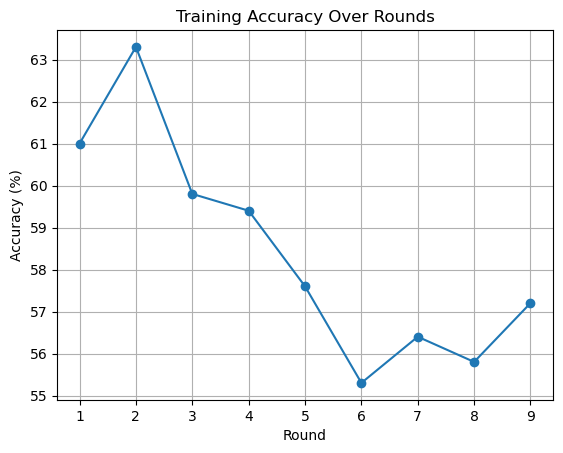

In [82]:
import matplotlib.pyplot as plt

# Assuming you have a list `accuracy_list` collecting accuracy each round
plt.plot(range(1, len(accuracy_list) + 1), [a * 100 for a in accuracy_list], marker='o')
plt.title("Training Accuracy Over Rounds")
plt.xlabel("Round")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()
